In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostRegressor
from lmfit import Model
from xgboost import XGBRegressor
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import neighbors
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_regression,f_regression
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
import umap

pl.style.use('seaborn')
pl.rc('font',family='Arial')

## Read in data

In [8]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")
test_data = pd.read_csv("SubCh1_TestData.csv")

train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

## Split into four data frames and combine into one

Each new df corresponds to a particular timepoint/treatment combination:

- A: 6hr untreated
- B: 24hr untreated
- C: 6hr treated
- D: 24hr treated

In [26]:
X_A = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_B = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_C = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_D = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

Y = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)]['DHA_IC50']

# rename columns:
X_A.columns = ['A' + str(i) for i in range(1,5541)]
X_B.columns = ['B' + str(i) for i in range(1,5541)]
X_C.columns = ['C' + str(i) for i in range(1,5541)]
X_D.columns = ['D' + str(i) for i in range(1,5541)]

X_A = X_A.reset_index().drop(['index'],axis=1)
X_B = X_B.reset_index().drop(['index'],axis=1)
X_C = X_C.reset_index().drop(['index'],axis=1)
X_D = X_D.reset_index().drop(['index'],axis=1)

# combine data frames:
X = pd.concat([X_A,X_B,X_C,X_D], axis=1)
X.head(10)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D5531,D5532,D5533,D5534,D5535,D5536,D5537,D5538,D5539,D5540
0,1.311350,-1.613464,-1.298663,-1.441343,-1.735923,0.173112,2.466366,1.383979,-0.115130,0.287468,...,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528
1,0.997722,-1.553994,-1.960600,-1.424590,0.023609,0.420973,1.128427,0.722659,1.878123,-0.065159,...,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568
2,0.389508,-2.139782,-0.584985,-1.085373,0.803247,0.766617,1.701689,0.926101,1.600687,0.435633,...,-0.070151,0.024133,-2.215227,-1.957654,-2.188635,-4.424748,-2.986927,-1.722201,-3.995680,-0.902979
3,0.348560,-1.562540,-0.586732,-0.834661,1.096979,0.121817,1.623373,-0.654405,0.221121,0.998601,...,-1.288305,0.806314,-3.733712,-1.990368,-1.633418,-5.533077,-3.283316,-2.104227,-5.767710,-2.177930
4,0.138276,-1.612280,-1.362990,-1.360318,0.488124,0.365410,0.739845,-0.654702,2.170263,0.630418,...,0.279816,0.115002,-1.305902,-0.679212,-2.099512,-5.955507,-0.920594,-1.626372,-4.422711,-1.408485
5,-0.332565,-1.280348,-0.817751,-0.480521,-0.098970,0.112246,0.773993,-0.969944,1.117705,0.872166,...,0.375290,1.113241,-4.016287,-1.327287,-2.375500,-4.379304,-2.752906,-1.939162,-3.500963,-0.796143
6,-1.140942,-0.460872,0.588564,-1.214647,1.210955,1.336895,-0.857090,-1.884711,-0.001943,1.320737,...,0.666558,-2.016912,-4.682891,-0.254524,-2.668047,-6.573239,-3.264155,-0.671344,-5.312867,-2.248219
7,0.426584,-1.118851,-0.938263,-1.442067,0.747063,0.268388,1.062841,0.494635,0.866481,0.501923,...,-1.793459,-0.116719,-4.535173,-0.537190,-2.472669,-6.261742,-3.134708,-1.969545,-5.157691,-2.637917
8,0.037085,-1.488644,-1.838770,-1.066493,-1.305085,0.059484,2.128986,-0.527511,1.616871,0.235093,...,-0.478144,0.125283,-5.360958,-2.386122,-1.886257,-6.127057,-3.231487,-2.349583,-4.977880,-1.047555
9,-0.037537,-1.495531,-1.801568,-0.526676,-1.831555,0.494413,1.286978,-1.589983,1.060466,0.836018,...,1.213397,-1.032989,-8.298501,-0.080207,-2.335635,-4.606785,-2.849864,-2.028372,-3.179649,-2.205214


## Univariate f-regression, using top k features

In [30]:
def drop_univ(X_orig, Y, features):
    X = StandardScaler().fit_transform(X_orig)
    X_uni = GenericUnivariateSelect(f_regression,'k_best', param=features).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    return X_uni

### Test on reshaped data frame, testing different numbers of features

In [79]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_med = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_med.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring='neg_median_absolute_error')))
    

results_unif = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_med)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_med']) 

In [81]:
X_uni.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.292943,2.016833,1.845393,3.028196,2.500009,3.398555,-1.832262,-2.797206,2.040974,2.315473,...,-0.887688,2.622818,0.456541,-0.558260,-0.267840,-2.729300,1.309034,2.028177,-0.264554,2.195769
1,-1.862115,0.876737,1.447845,0.363864,-0.143767,0.191846,-1.231272,-1.575531,1.227064,0.379158,...,-0.669492,-0.426987,-0.039873,0.492228,2.270057,0.798605,1.540293,1.145054,2.077086,-0.464697
2,-0.022030,-0.054085,0.512837,0.075053,-0.269357,0.341495,-0.120556,0.342170,-0.260822,0.917548,...,-0.112742,-1.120642,-1.732666,-0.914019,-2.002187,1.050166,0.048109,-1.267189,0.086802,-1.155420
3,1.311045,1.271229,0.269660,1.266081,0.892360,-0.471573,-0.541877,-1.122765,0.043002,0.700775,...,-2.106042,-0.413747,2.332550,1.953799,-0.809012,-0.875863,-1.292227,0.450239,-1.740346,-1.346451
4,0.698626,0.757369,0.098395,-0.270719,-0.766589,-1.095904,0.367818,0.453151,0.028027,-0.082555,...,1.082295,-1.792682,-0.798296,0.132350,1.037966,0.825620,0.869621,-0.424967,1.997906,0.614622


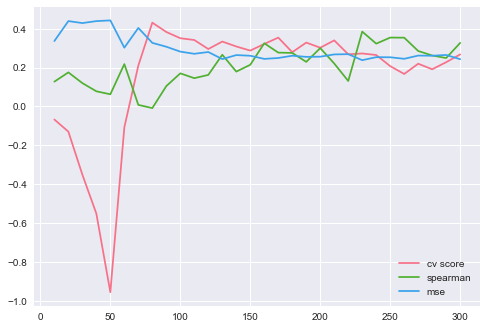

In [80]:
sns.set_palette("husl", 3)

pl.plot(results_unif['threshold'],results_unif['cv'])
pl.plot(results_unif['threshold'],results_unif['spearman'])
pl.plot(results_unif['threshold'],results_unif['mse'])
pl.legend(['cv score','spearman','mse'])
pl.show()

## Test on only 24hr, treated data frame

In [77]:
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_med = []

for j in np.arange(10,310,10):
    X_uni = drop_univ(X_D,Y,j)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_med.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring='neg_median_absolute_error')))
    

results_unif_sub = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_med)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_med']) 

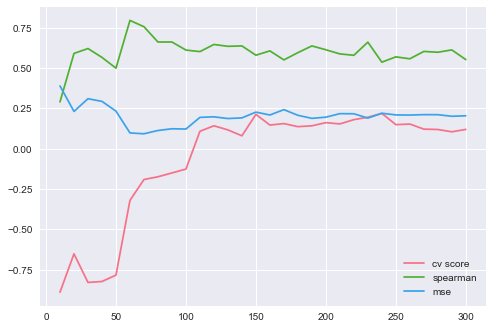

In [78]:
sns.set_palette("husl", 3)

pl.plot(results_unif_sub['threshold'],results_unif_sub['cv'])
pl.plot(results_unif_sub['threshold'],results_unif_sub['spearman'])
pl.plot(results_unif_sub['threshold'],results_unif_sub['mse'])
pl.legend(['cv score','spearman','mse'])
pl.show()

### Conclusion: treated 24hr is still best to use
- Optimal no. of features between 60 and 240 depending on metric